In [1]:
import sys
!{sys.executable} -m pip install pandas numpy scikit-learn

import pandas as pd
import numpy as np
import re

import pickle
from datetime import datetime
import time

import matplotlib.pyplot as plt

DTYPE_DICT = {"INCIDENT_TYPE_DESC":"uint16","UNITS_ONSCENE":"uint8","TOTAL_INCIDENT_DURATION":"uint16","ACTION_TAKEN1_DESC":"int16","ACTION_TAKEN2_DESC":"int16","ACTION_TAKEN3_DESC":"int16","PROPERTY_USE_DESC":"int16","BOROUGH_DESC":"uint8","SEASON":"uint8","TIME_OF_DAY":"uint8","WEEKDAY":"uint8","HOUR":"uint8","MONTH":"uint8","YEAR":"uint16"}

In [2]:
data = pd.read_csv("preprocessed.csv.gzip",compression="gzip",dtype=DTYPE_DICT)
data.head(10)

,INCIDENT_TYPE_DESC,UNITS_ONSCENE,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,ACTION_TAKEN2_DESC,ACTION_TAKEN3_DESC,PROPERTY_USE_DESC,BOROUGH_DESC,SEASON,TIME_OF_DAY,WEEKDAY,HOUR,MONTH,YEAR
0,300,1,1186,0,0,0,999,2,0,0,1,0,1,2013
1,735,3,1769,86,0,0,999,1,0,0,1,0,1,2013
2,300,1,841,0,0,0,999,5,0,0,1,0,1,2013
3,412,4,2259,44,64,82,429,5,0,0,1,0,1,2013
4,735,6,1387,86,0,0,999,5,0,0,1,0,1,2013
5,735,3,935,86,0,0,999,4,0,0,1,0,1,2013
6,353,1,1598,64,0,0,429,1,0,0,1,0,1,2013
7,651,4,438,86,0,0,960,5,0,0,1,0,1,2013
8,331,1,1132,70,0,0,429,2,0,0,1,0,1,2013
9,710,6,319,0,0,0,999,4,0,0,1,0,1,2013


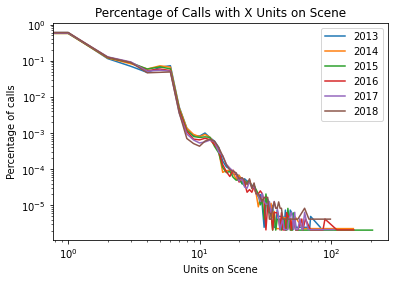

In [3]:
for year in data['YEAR'].unique():
    d = data[data.YEAR == year].UNITS_ONSCENE.value_counts()
    tot = data[data.YEAR == year].shape[0]
    k = d.keys().sort_values()
    res = []
    for i in k:
        res.append(d[i] / tot)
    plt.plot(k, res, label=str(year))
plt.title("Percentage of Calls with X Units on Scene")
plt.xlabel("Units on Scene")
plt.ylabel("Percentage of calls")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


C:\Temp\ipykernel_18604\2127839409.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d[year][blu[borough]] = dy[data.BOROUGH_DESC == borough].shape[0] / tot


Text(0.5, 0, 'Percentage of Calls')

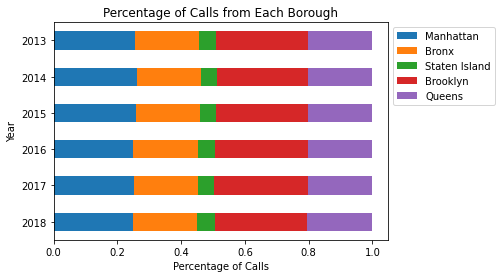

In [5]:
blu = ["Year","Manhattan","Bronx","Staten Island","Brooklyn","Queens"]
d = {}
tot = data.shape[0]
for year in data.YEAR.unique():
    d[year] = {}
    dy = data[data.YEAR == year]
    tot = dy.shape[0]
    for borough in dy.BOROUGH_DESC.unique():
        d[year][blu[borough]] = dy[data.BOROUGH_DESC == borough].shape[0] / tot
    del(dy)
rows = []
k = list(d.keys())
k.sort(reverse=True)
for yr in k:
    # print(yr, d[yr])
    row = [yr]
    for b in blu:
        if b == "Year":
            continue
        row.append(d[yr][b])
    rows.append(row)
df = pd.DataFrame(rows, columns=blu)
fig, ax = plt.subplots()
df.plot(
    x="Year",
    kind="barh",
    stacked=True,
    title="Percentage of Calls from Each Borough",
    mark_right=True,
    ax=ax
)
ax.legend(bbox_to_anchor=(1,1),loc="upper left")
ax.set_xlabel("Percentage of Calls")

In [5]:
# Borrowing from preprocess; want to analyze an extra few columns we don't use otherwise
DROP_COLUMNS = ["INCIDENT_TYPE_DESC","UNITS_ONSCENE","TOTAL_INCIDENT_DURATION","ACTION_TAKEN1_DESC","ACTION_TAKEN2_DESC","PROPERTY_USE_DESC","ACTION_TAKEN3_DESC","IM_INCIDENT_KEY","FIRE_BOX", "LAST_UNIT_CLEARED_DATE_TIME", "HIGHEST_LEVEL_DESC", "STREET_HIGHWAY", "ZIP_CODE", "FLOOR", "CO_DETECTOR_PRESENT_DESC", "FIRE_ORIGIN_BELOW_GRADE_FLAG", "STORY_FIRE_ORIGIN_COUNT", "FIRE_SPREAD_DESC", "DETECTOR_PRESENCE_DESC", "AES_PRESENCE_DESC", "STANDPIPE_SYS_PRESENT_FLAG"]

def extract_year(row):
    # 2013-2018, i think
    # 2014-2017 just to be safe
    x = row["INCIDENT_DATE_TIME"]
    s = datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p').timetuple()
    return s.tm_year

def rt_filt(row):
    idt = datetime.strptime(row["INCIDENT_DATE_TIME"], '%m/%d/%Y %I:%M:%S %p')
    adt = datetime.strptime(row["ARRIVAL_DATE_TIME"], '%m/%d/%Y %I:%M:%S %p')
    return (adt - idt).total_seconds()

data = None
for i in range(8):
    print("Processing file {} of 8:".format(i+1),end="")
    x = pd.read_csv("OriginalCSVs/file{}.csv".format(i+1), low_memory=False)
    print("R",end="")
    x.drop(DROP_COLUMNS, axis=1, inplace=True)
    print("D",end="")
    x.dropna(axis=0, subset=["INCIDENT_DATE_TIME", "ARRIVAL_DATE_TIME", "BOROUGH_DESC"], inplace=True)
    print("D",end="")
    x.fillna(0, inplace=True)
    print("F",end="")
    
    x["BOROUGH_DESC"] = x.apply(lambda row : int(row["BOROUGH_DESC"][0]), axis=1)
    print("B",end="")

    x["YEAR"] = x.apply(lambda row : extract_year(row), axis=1)
    print("Y",end="")
    x["RESPONSE_TIME"] = x.apply(lambda row : rt_filt(row), axis=1)
    print("R",end='')
    x.drop(["INCIDENT_DATE_TIME", "ARRIVAL_DATE_TIME"], axis=1, inplace=True)
    print("D",end='')

    x = x.astype({"YEAR":"uint16","BOROUGH_DESC":"uint8","RESPONSE_TIME":"uint32"})
    print("T",end="")
    if data is None:
        data = x
    else:
        data = pd.concat([data,x])
    print("; Finished file {}".format(i+1))

data = data.astype({"YEAR":"uint16","BOROUGH_DESC":"uint8","RESPONSE_TIME":"uint32"})
print("Done.")
data.head()

Processing file 1 of 8:RDDFBYRDT; Finished file 1
Processing file 2 of 8:RDDFBYRDT; Finished file 2
Processing file 3 of 8:RDDFBYRDT; Finished file 3
Processing file 4 of 8:RDDFBYRDT; Finished file 4
Processing file 5 of 8:RDDFBYRDT; Finished file 5
Processing file 6 of 8:RDDFBYRDT; Finished file 6
Processing file 7 of 8:RDDFBYRDT; Finished file 7
Processing file 8 of 8:RDDFBYRDT; Finished file 8
Done.


,BOROUGH_DESC,YEAR,RESPONSE_TIME
0,2,2013,843
1,1,2013,506
2,5,2013,218
3,5,2013,316
4,5,2013,278


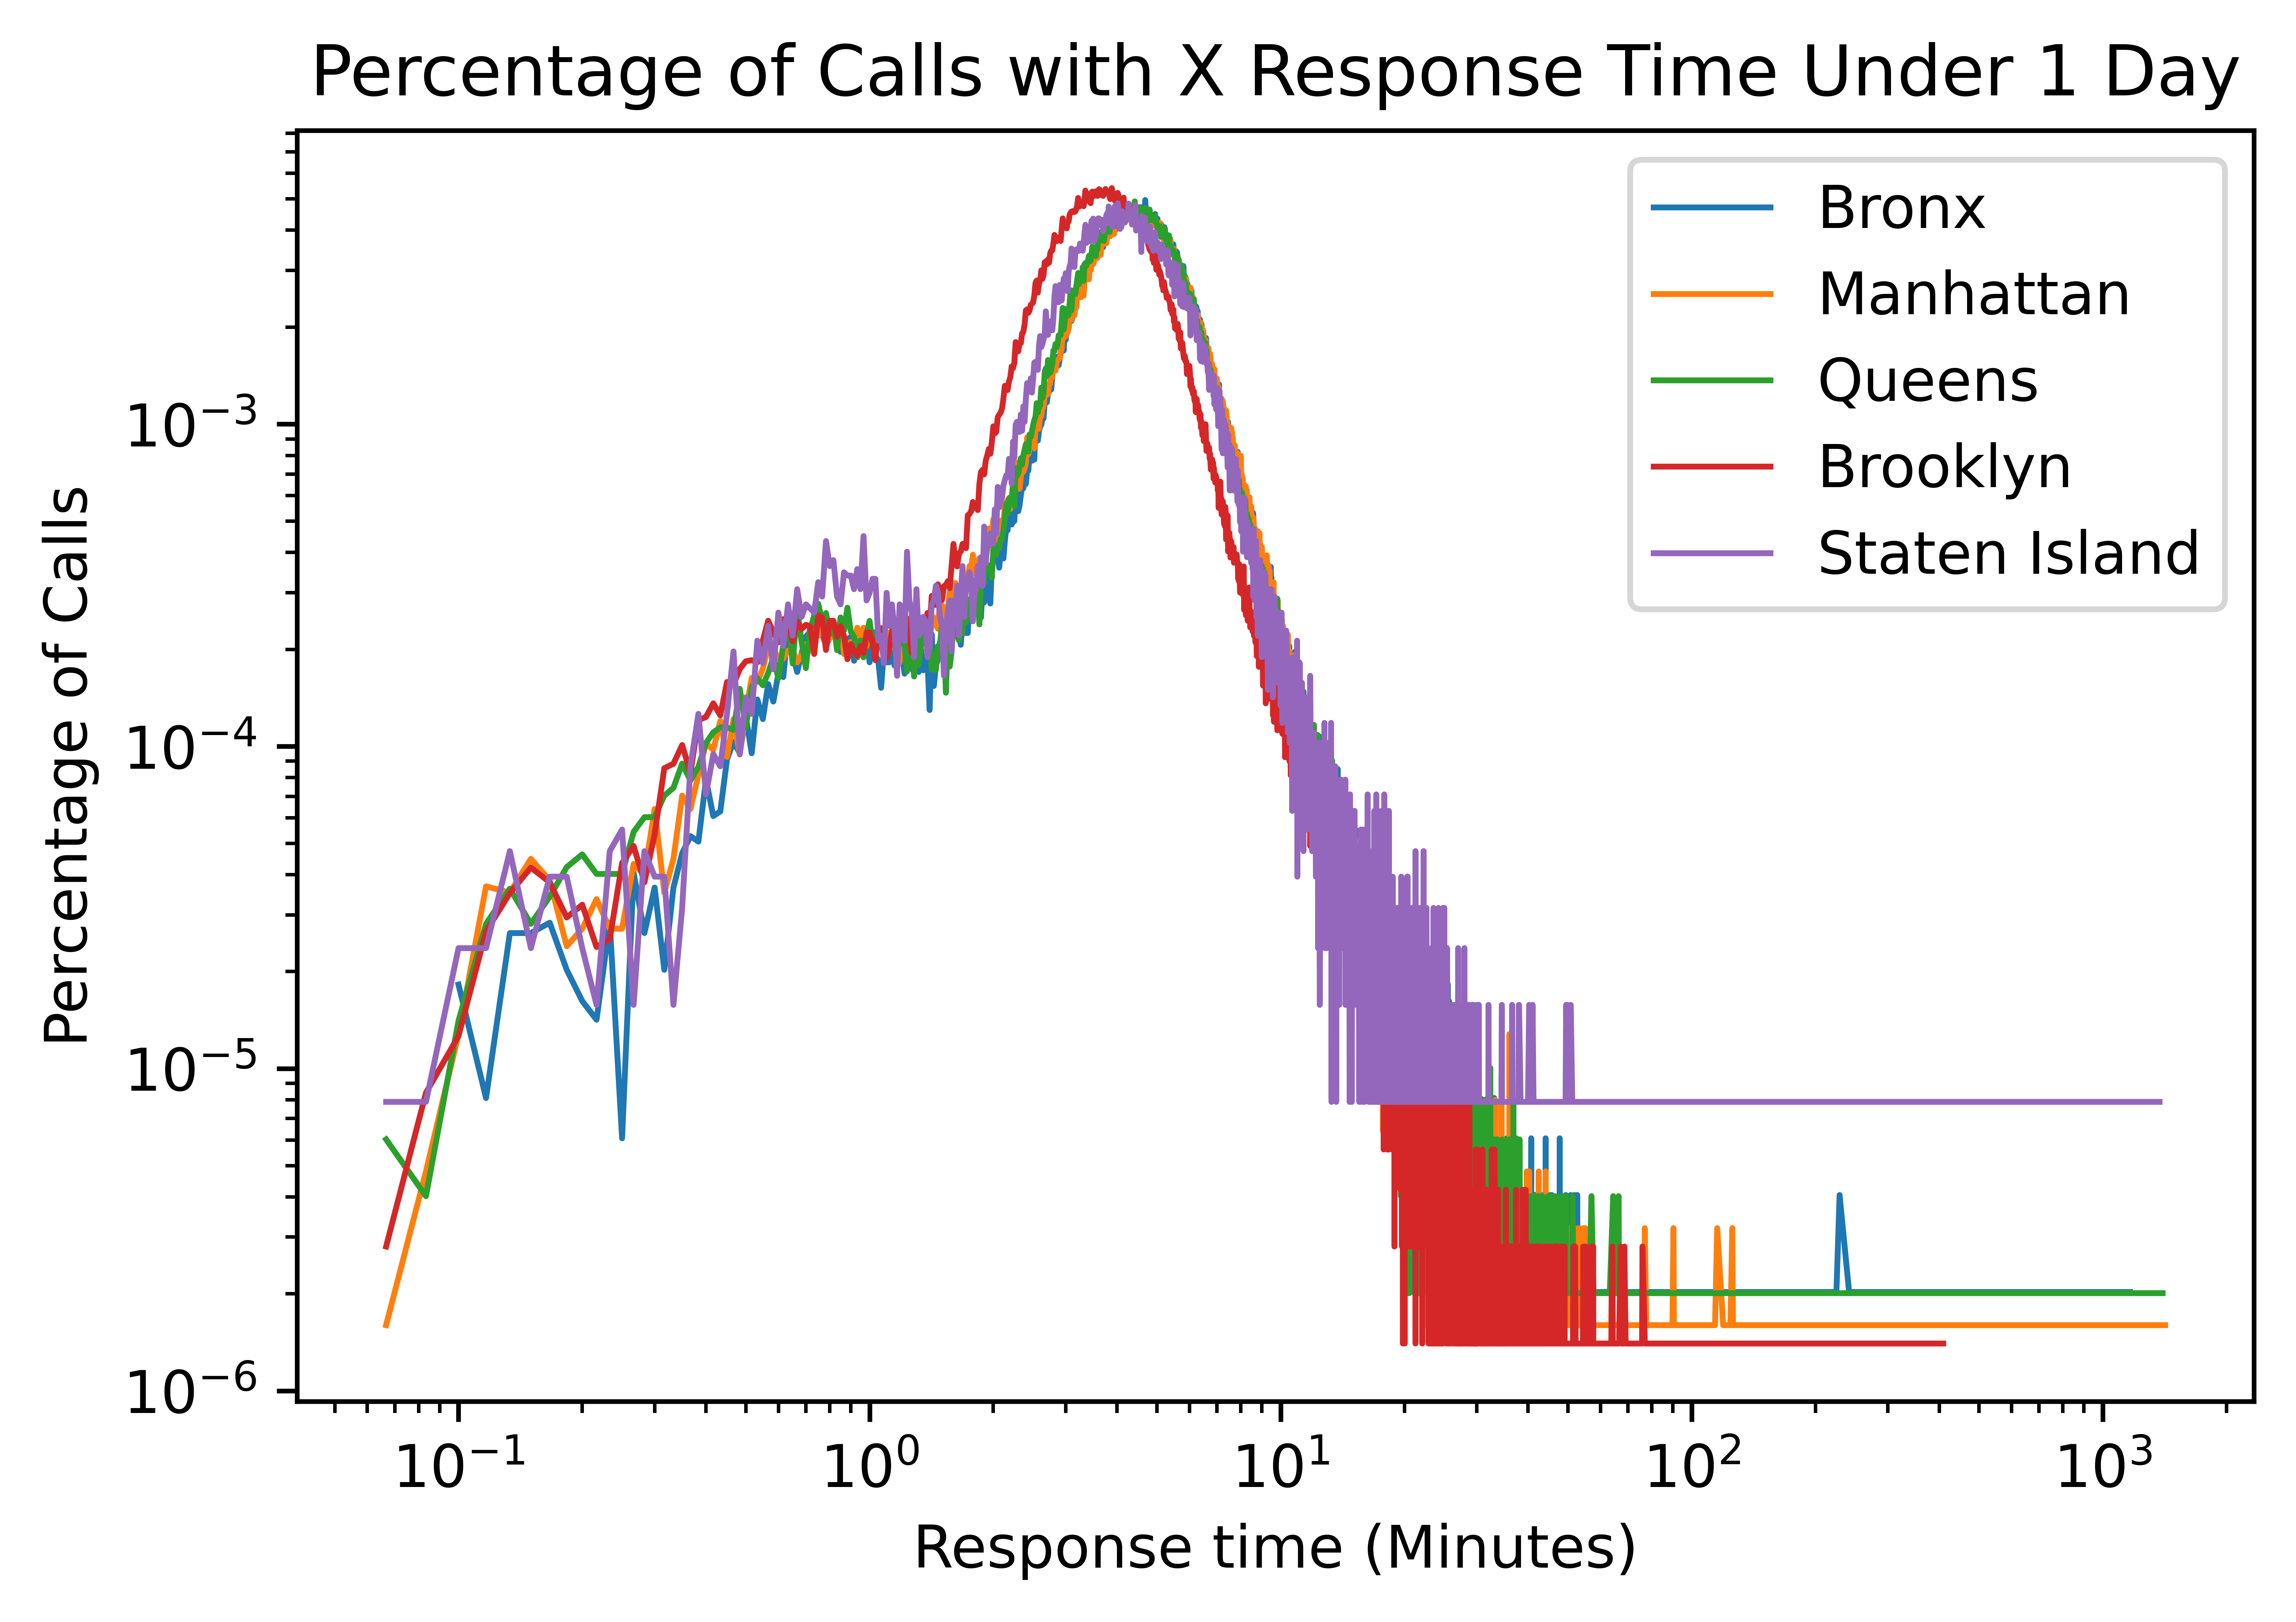

In [24]:
plt.figure(dpi=1200)
plt.title("Percentage of Calls with X Response Time Under 1 Day")
plt.xlabel("Response time (Minutes)")
plt.ylabel("Percentage of Calls")
blu = ["","Manhattan","Bronx","Staten Island","Brooklyn","Queens"]
for borough in data.BOROUGH_DESC.unique():
# for borough in [1]:
    d = data[data.BOROUGH_DESC == borough].RESPONSE_TIME.value_counts()
    tot = data[data.BOROUGH_DESC == borough].RESPONSE_TIME.shape[0]
    k = d.keys().sort_values()
    x = []
    res = []
    for i in k:
        if i < 86400:
            x.append(i / 60)
            res.append(d[i] / tot)
    plt.plot(x, res, label=str(blu[borough]), linewidth=1)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()
